# Imbalanced Data

## Koneksi ke Database

In [1]:
import pymysql
import pandas as pd

# Konfigurasi koneksi
host = "localhost"
user = "root"        # ganti sesuai user MySQL kamu
password = ""        # ganti sesuai password MySQL kamu
database = "psd"

# Buat koneksi
connection = pymysql.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

try:
    # Baca data dari tabel iris_full
    query = "SELECT * FROM iris_full"
    df = pd.read_sql(query, connection)

    # Tampilkan 5 data teratas
    print(df.head())

finally:
    connection.close()


   id        Class  sepal length  sepal width  petal length  petal width
0  36  Iris-setosa           5.0          3.2           1.2          0.2
1  37  Iris-setosa           5.5          3.5           1.3          0.2
2  38  Iris-setosa           4.9          3.1           1.5          0.1
3  39  Iris-setosa           4.4          3.0           1.3          0.2
4  40  Iris-setosa           5.1          3.4           1.5          0.2


C:\Users\FIKRI\AppData\Local\Temp\ipykernel_7380\2193528993.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


##  Membuat Scatter Plot untuk mengetahui data yang tidak seimbang

Index(['id', 'Class', 'sepal length', 'sepal width', 'petal length',
       'petal width'],
      dtype='object')


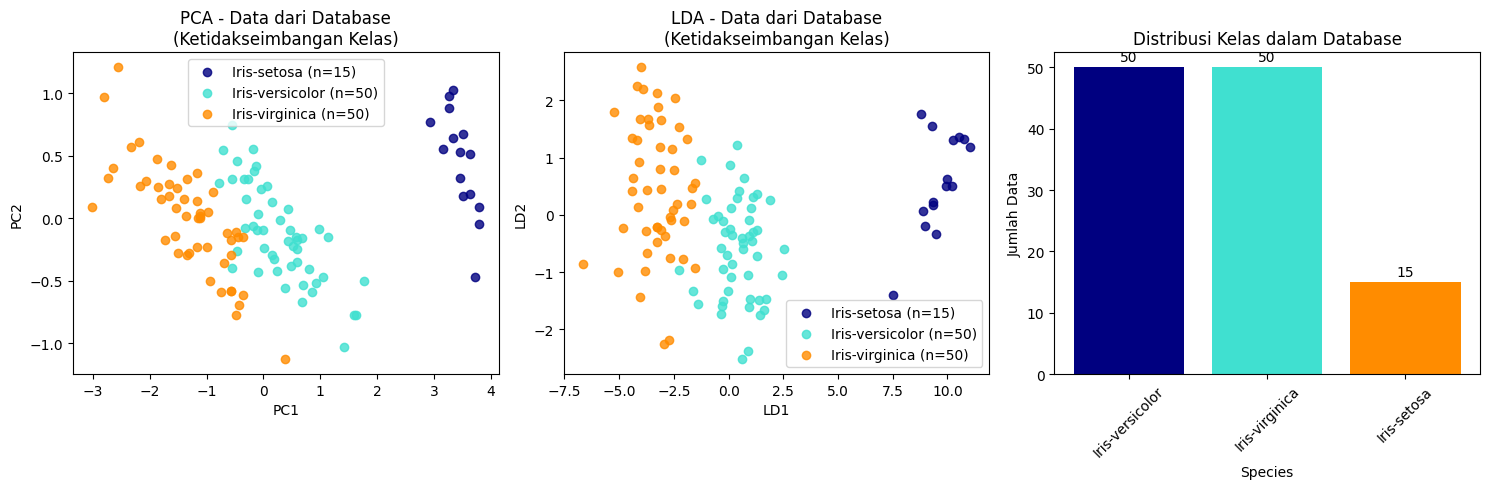


Explained variance ratio (database): [0.8962252 0.0647599]


In [2]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# === Pastikan nama kolom ===
print(df.columns)

# Gunakan kolom fitur sesuai database kamu
X_db = df[['sepal length', 'sepal width', 'petal length', 'petal width']].values
y_db = df['Class'].values  # target ada di kolom 'Class'

# Mapping kelas (sesuaikan dengan isi kolom Class)
species_mapping = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}
y_numeric = np.array([species_mapping[s] for s in y_db])
target_names_db = list(species_mapping.keys())

# PCA (2 dimensi)
pca_db = PCA(n_components=2)
X_r_db = pca_db.fit(X_db).transform(X_db)

# LDA (2 dimensi)
lda_db = LinearDiscriminantAnalysis(n_components=2)
X_r2_db = lda_db.fit(X_db, y_numeric).transform(X_db)

# === Visualisasi ===
plt.figure(figsize=(15, 5))

# ---- Plot PCA ----
plt.subplot(1, 3, 1)
colors = ["navy", "turquoise", "darkorange"]
for color, i, target_name in zip(colors, [0, 1, 2], target_names_db):
    mask = y_numeric == i
    plt.scatter(X_r_db[mask, 0], X_r_db[mask, 1],
                color=color, alpha=0.8,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA - Data dari Database\n(Ketidakseimbangan Kelas)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# ---- Plot LDA ----
plt.subplot(1, 3, 2)
for color, i, target_name in zip(colors, [0, 1, 2], target_names_db):
    mask = y_numeric == i
    plt.scatter(X_r2_db[mask, 0], X_r2_db[mask, 1],
                color=color, alpha=0.8,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA - Data dari Database\n(Ketidakseimbangan Kelas)")
plt.xlabel("LD1")
plt.ylabel("LD2")

# ---- Plot distribusi kelas ----
plt.subplot(1, 3, 3)
species_counts = df['Class'].value_counts()
plt.bar(species_counts.index, species_counts.values,
        color=['navy', 'turquoise', 'darkorange'])
plt.title("Distribusi Kelas dalam Database")
plt.xlabel("Species")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
for i, v in enumerate(species_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nExplained variance ratio (database): {pca_db.explained_variance_ratio_}")


##  Imbalanced Data Menggunakan Smote

Distribusi sebelum SMOTE: Counter({1: 50, 2: 50, 0: 15})
Distribusi setelah SMOTE: Counter({0: 50, 1: 50, 2: 50})


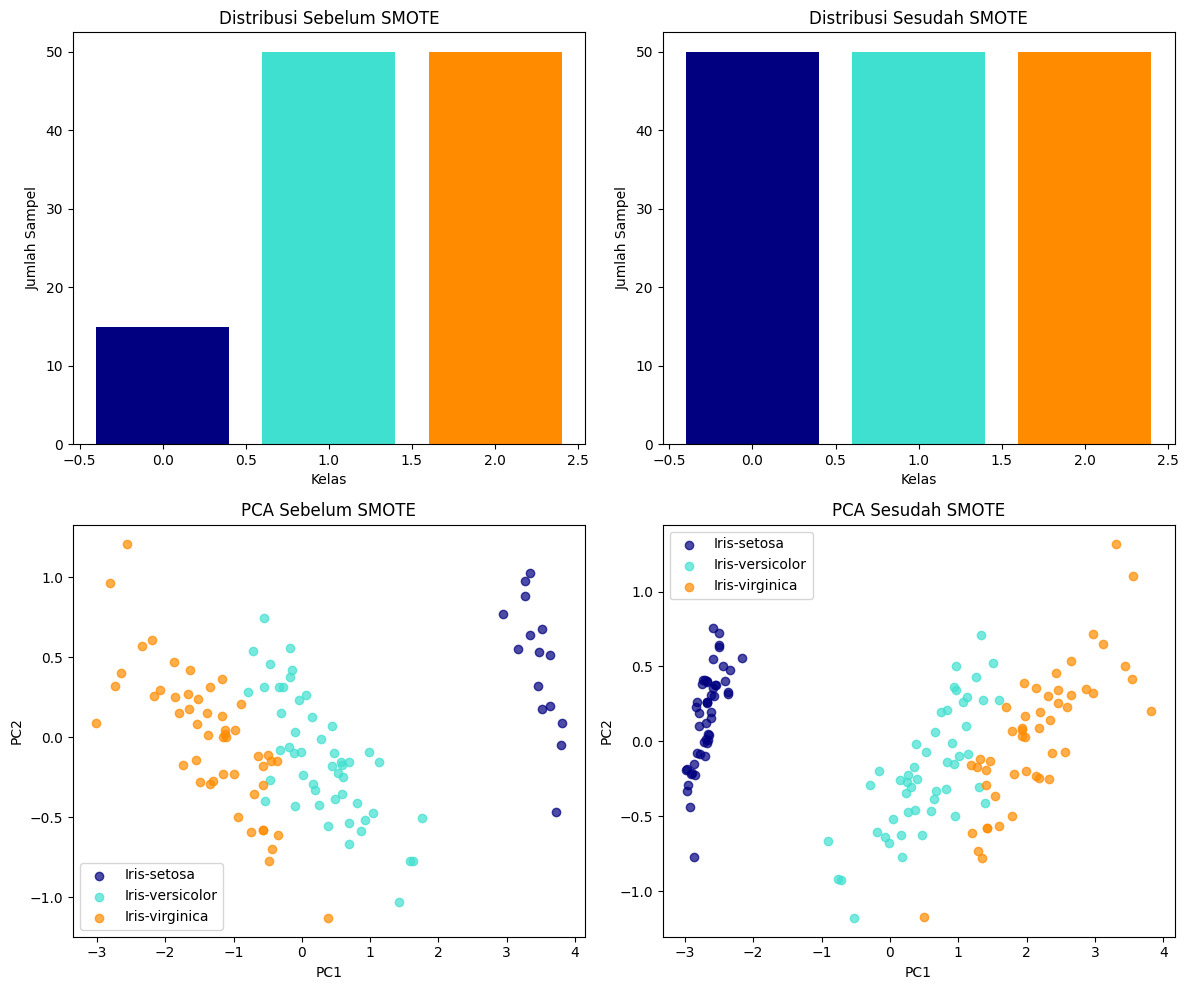

In [3]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 1. Distribusi sebelum SMOTE
# ===============================
print("Distribusi sebelum SMOTE:", Counter(y_numeric))

# ===============================
# 2. Terapkan SMOTE
# ===============================
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_db, y_numeric)

print("Distribusi setelah SMOTE:", Counter(y_res))

# ===============================
# 3. PCA untuk reduksi ke 2 dimensi
# ===============================
pca = PCA(n_components=2)
X_pca_before = pca.fit_transform(X_db)
X_pca_after = pca.fit_transform(X_res)

# ===============================
# 4. Visualisasi
# ===============================
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

colors = ["navy", "turquoise", "darkorange"]
target_names_db = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

# --- Distribusi kelas sebelum ---
ax[0,0].bar(Counter(y_numeric).keys(), Counter(y_numeric).values(),
            color=colors)
ax[0,0].set_title("Distribusi Sebelum SMOTE")
ax[0,0].set_xlabel("Kelas")
ax[0,0].set_ylabel("Jumlah Sampel")

# --- Distribusi kelas sesudah ---
ax[0,1].bar(Counter(y_res).keys(), Counter(y_res).values(),
            color=colors)
ax[0,1].set_title("Distribusi Sesudah SMOTE")
ax[0,1].set_xlabel("Kelas")
ax[0,1].set_ylabel("Jumlah Sampel")

# --- Scatter plot PCA sebelum ---
for color, i, target_name in zip(colors, [0, 1, 2], target_names_db):
    mask = y_numeric == i
    ax[1,0].scatter(X_pca_before[mask, 0], X_pca_before[mask, 1],
                    color=color, alpha=0.7, label=target_name)
ax[1,0].legend(loc="best", shadow=False, scatterpoints=1)
ax[1,0].set_title("PCA Sebelum SMOTE")
ax[1,0].set_xlabel("PC1")
ax[1,0].set_ylabel("PC2")

# --- Scatter plot PCA sesudah ---
for color, i, target_name in zip(colors, [0, 1, 2], target_names_db):
    mask = y_res == i
    ax[1,1].scatter(X_pca_after[mask, 0], X_pca_after[mask, 1],
                    color=color, alpha=0.7, label=target_name)
ax[1,1].legend(loc="best", shadow=False, scatterpoints=1)
ax[1,1].set_title("PCA Sesudah SMOTE")
ax[1,1].set_xlabel("PC1")
ax[1,1].set_ylabel("PC2")

plt.tight_layout()
plt.show()
